# SAMap preprocess
With leiden-based neighborhoods

In [9]:
from samap.mapping import SAMAP
from samalg import SAM
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings(action='ignore')
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Set parameters

In [2]:
# species A
sp_stage_A='AmpG4'
abbr_A='bf' # must be equal to filename under blast map folder
h5ad_A='Amp_G4.h5ad'

# species B
sp_stage_B='NV24hr'
abbr_B='nv' # must be equal to filename under blast map folder
h5ad_B='Gastrula24hrFINAL.h5ad'

# blast maps and id maps
g_map_folder='./maps_prot/'

## Read gene name mapping

Parse mapping of transcript ids vs gene names used in the anndata object

In [3]:
with open(g_map_folder+'/'+abbr_A+'_idmap.csv') as f:
    idmap_A=[tuple(line) for line in csv.reader(f)][2:]

with open(g_map_folder+'/'+abbr_B+'_idmap.csv') as f:
    idmap_B=[tuple(line) for line in csv.reader(f)][2:]

print(abbr_A+" first five gene ids:")
print(idmap_A[:5])
print(abbr_B+" first five gene ids:")
print(idmap_B[:5])

bf first five gene ids:
[('XM_035817741.1', 'Ppp4r4'), ('XM_035817733.1', 'Ppp4r4'), ('XM_035817723.1', 'Ppp4r4'), ('XM_035817707.1', 'Ppp4r4'), ('XM_035827936.1', 'LOC118420880')]
nv first five gene ids:
[('NV2t025877001.1', 'XPO4-like-1'), ('NV2t025878001.1', 'NV2.25878'), ('NV2t025879001.1', 'XPO4-like-3'), ('NV2t025880001.1', 'RISC-like-1'), ('NV2t025881001.1', 'NV2.25881')]


# Running SAMap

## Loading in raw data

Instantiate the SAMAP object.

In [4]:
sm = SAMAP(
        {abbr_A : h5ad_A , abbr_B : h5ad_B},
        f_maps = g_map_folder,
        names = {abbr_A : idmap_A , abbr_B : idmap_B},
        save_processed=False
    )

Processing data bf from:
Amp_G4.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8736902101496475
Iteration: 2, Convergence: 0.012774499544245477
Computing the UMAP embedding...
Elapsed time: 17.965943098068237 seconds
Not updating the manifold...
Processing data nv from:
Gastrula24hrFINAL.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8226680874565728
Iteration: 2, Convergence: 0.021857748577651423
Computing the UMAP embedding...
Elapsed time: 40.50432014465332 seconds
Not updating the manifold...
16605 `bf` gene symbols match between the datasets and the BLAST graph.
13718 `nv` gene symbols match between the datasets and the BLAST graph.


Show unintegrated umaps.

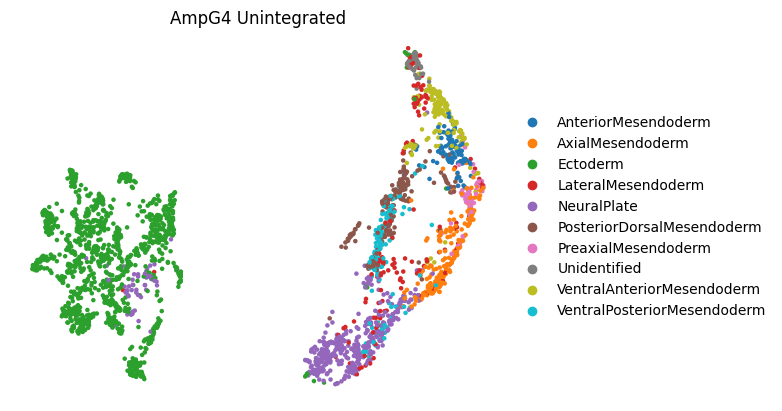

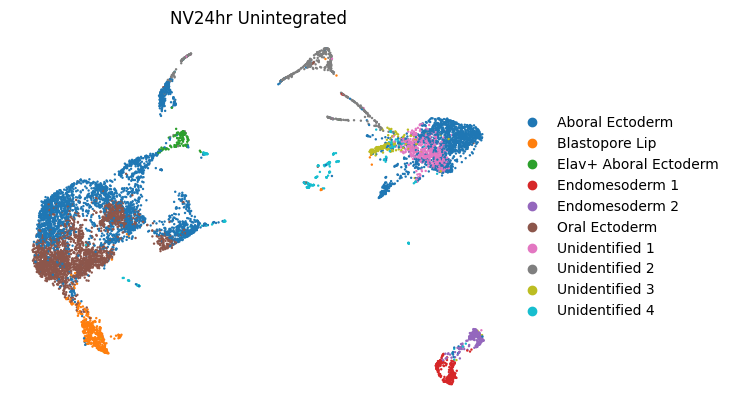

In [5]:
sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap',
                    color='celltype_fine',
                title=(sp_stage_A+' Unintegrated'),
                    frameon=False)

sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap',
                title=(sp_stage_B+' Unintegrated'),
                    color='cell_type',
                    frameon=False)

## Run SAMap

In [6]:
sm.run(ncpus=4)

Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 5.848006248474121
Correcting data with means. 9.482746601104736
Expanding neighbourhoods of species bf...
Expanding neighbourhoods of species nv...
Indegree coarsening
0/1 (0, 12830)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 1 complete.
Alignment scores:
          bf        nv
bf  0.000000  0.420412
nv  0.347971  0.000000
Calculating gene-gene correlations in the homology graph...
Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 4.989579200744629
Correcting data with means. 7.866102933883667
Expanding neighbourhoods of species bf...
Expanding neighbourhoods of species nv...
Indegree coarsening
0/1 (0, 12830)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          bf        nv
bf  0.000000  0.

Save samap object.

In [10]:
save_object(sm,'sam_processed.pkl')

## Visualizing the combined projection

<Axes: title={'center': 'SAMap UMAP AmpG4 (red) vs NV24hr (blue)'}>

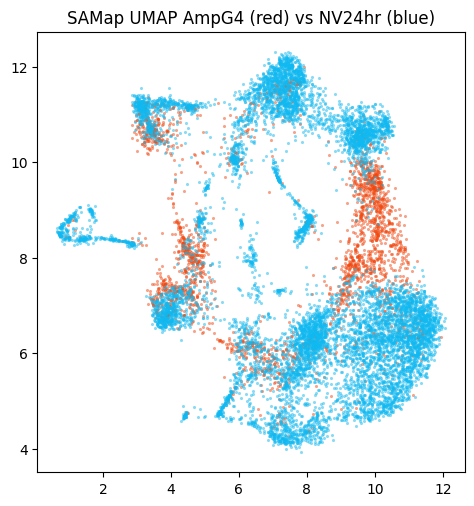

In [11]:
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)
fig.tight_layout()
ax.set_title('SAMap UMAP '+sp_stage_A+' (red) vs '+sp_stage_B+' (blue)')
sm.scatter(COLORS={abbr_B:'#10b9f1',abbr_A:'#f14810'},axes=ax,ss={abbr_A:5,abbr_B:5},alpha=0.5)

# Save parameters

In [12]:
params_d={
'sp_stage_A' : sp_stage_A,
'abbr_A' : abbr_A,
'h5ad_A' : h5ad_A,
'sp_stage_B' : sp_stage_B,
'abbr_B' : abbr_B,
'h5ad_B' : h5ad_B,
'g_map_folder' : g_map_folder}

pd.DataFrame.from_dict(data=params_d, orient='index').to_csv('samap_parameters.csv', header=False)